In [2]:
from sqlalchemy import create_engine
import pandas as pd

In [1]:
pip install --force-reinstall 'sqlalchemy<2.0.0'

  Using cached SQLAlchemy-1.4.47-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.6 MB)
  Using cached greenlet-2.0.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (618 kB)
  Attempting uninstall: greenlet
    Found existing installation: greenlet 2.0.2
    Uninstalling greenlet-2.0.2:
      Successfully uninstalled greenlet-2.0.2
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 1.4.47
    Uninstalling SQLAlchemy-1.4.47:
      Successfully uninstalled SQLAlchemy-1.4.47
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.47 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
%matplotlib inline

In [5]:
cnxn_string = (
    "postgresql+psycopg2://{username}:{pswd}@{host}:{port}/{database}"
)
print(cnxn_string)

postgresql+psycopg2://{username}:{pswd}@{host}:{port}/{database}


In [6]:
engine = create_engine(
cnxn_string.format(
username="postgres",
pswd="reuben80kihiu",
host="localhost",
port=5432,
database="sqlda"
)
)

In [7]:
data = pd.read_csv(
  "~/Documents/Python-Crash-Course-Assignment/sql/public_transportation_statistics_by_zip_code.csv",
dtype={'zip_code':str}
)

In [8]:
data.head()

,zip_code,public_transportation_pct,public_transportation_population
0,01379,3.3,13
1,01440,0.4,34
2,01505,0.9,23
3,01524,0.5,20
4,01529,1.8,32


In [9]:
import csv
from io import StringIO

def psql_insert_copy(table, conn, keys, data_iter):
    # gets a DBAPI connection that can provide a cursor 
    dbapi_conn = conn.connection
    with dbapi_conn.cursor() as cur:
        s_buf = StringIO()
        writer = csv.writer(s_buf) 
        writer.writerows(data_iter) 
        s_buf.seek(0)

        columns = ', '.join('"{}"'.format(k) for k in keys) 
        if table.schema:
            table_name = '{}.{}'.format(table.schema, table.name) 
        else:
            table_name = table.name

        sql = 'COPY {} ({}) FROM STDIN WITH CSV'.format(
            table_name, 
            columns
        )
        cur.copy_expert(sql=sql, file=s_buf)

data.to_sql(
    'public_transportation_by_zip', 
    engine, 
    if_exists='replace', 
    method=psql_insert_copy
)


In [10]:
data.max()

zip_code                            99929
public_transportation_pct           100.0
public_transportation_population    35139
dtype: object

In [11]:
data.min()

zip_code                                  00601
public_transportation_pct          -666666666.0
public_transportation_population              0
dtype: object

In [12]:
engine.execute("""
SELECT
MAX(public_transportation_pct) AS max_pct,
MIN(public_transportation_pct) AS min_pct
FROM public_transportation_by_zip;
""").fetchall()

/tmp/ipykernel_35063/2004987698.py:1: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  engine.execute("""


[(100.0, -666666666.0)]

In [13]:
engine.execute(""" 
    SELECT
        (public_transportation_pct > 10) AS is_high_public_transport,
        COUNT(s.customer_id) * 1.0 / COUNT(DISTINCT c.customer_id) AS sales_per_customer
    FROM
        customers c
    INNER JOIN 
        public_transportation_by_zip t 
        ON t.zip_code = c.postal_code
    LEFT JOIN 
        sales s
        ON s.customer_id = c.customer_id 
    WHERE
        public_transportation_pct >= 0 
    GROUP BY
        1
    LIMIT
    10
""").fetchall()

[(False, Decimal('0.71569054583929793988')),
 (True, Decimal('0.83159379407616361072'))]

<Axes: ylabel='Frequency'>

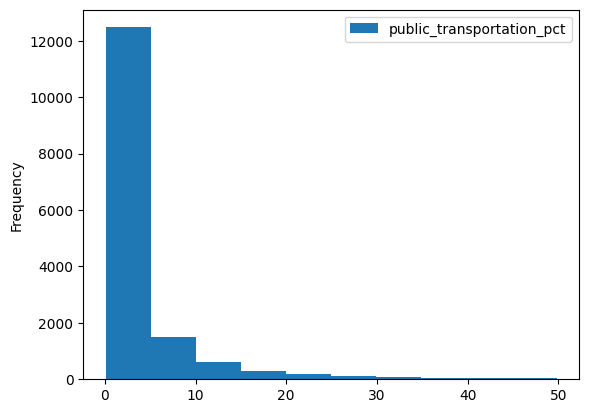

In [14]:
data = pd.read_sql_query(""" 
    SELECT 
        *
    FROM 
        public_transportation_by_zip 
    WHERE 
        public_transportation_pct > 0
    AND 
        public_transportation_pct < 50
""", engine) 
data.plot.hist(y='public_transportation_pct')

In [15]:
%time data.to_sql('public_transportation_by_zip', engine, if_exists='replace', method=psql_insert_copy)

%time data.to_sql('public_transportation_by_zip', engine, if_exists='replace')

CPU times: user 69.4 ms, sys: 8.13 ms, total: 77.5 ms
Wall time: 148 ms
CPU times: user 206 ms, sys: 0 ns, total: 206 ms
Wall time: 432 ms


412

In [16]:
data = pd.read_sql_query(""" 
    SELECT
        10 * ROUND(public_transportation_pct/10) AS public_transport,
        COUNT(s.customer_id) * 1.0 / COUNT(DISTINCT c.customer_id) AS sales_per_customer
    FROM 
        customers c
    INNER JOIN 
        public_transportation_by_zip t 
        ON t.zip_code = c.postal_code
    LEFT JOIN 
        sales s 
        ON s.customer_id = c.customer_id 
    WHERE 
        public_transportation_pct >= 0
    GROUP BY 
        1
""", engine)

data.to_csv('~/Documents/Python-Crash-Course-Assignment/sql/sales_vs_public_transport_pct.csv')